In [1]:
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('comment_data.csv', encoding_errors='ignore', header=None).sample(10000, random_state=42)
df.columns = ('sentiment', 'id', 'timestamp', 'query', 'user', 'text')
df.head()

,sentiment,id,timestamp,query,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [3]:
df.drop(columns=['id','timestamp','query','user'],inplace=True)

In [4]:
data = df['text']
labels = np.array(df['sentiment'])

In [6]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)
def tweet(words):
    tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,reduce_len=True)
    tweet = tweet_tokenizer.tokenize(words)
    return tweet
        

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [7]:
data = data.apply(denoise_text)

In [8]:
print('Before: {}'. format(list(df['text'][:2])))
print('---')
print('After: {}'. format(list(data[:2])))

Before: ['@chrishasboobs AHHH I HOPE YOUR OK!!! ', '@misstoriblack cool , i have no tweet apps  for my razr 2']
---
After: ['chrishasboobs ahhh hope ok', 'misstoriblack cool tweet apps razr']


In [9]:
X_train, X_test, y_train, y_test = test = train_test_split(data, labels,test_size=0.20,
                                                           random_state=1,
                                                           stratify = labels)

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)+1
VOCAB_SIZE

15758

In [11]:
maxlen = max([len(x) for x in X_train])
maxlen = 50

In [12]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = pad_sequences(train_sequences,maxlen=maxlen,padding='post',truncating='post')
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = pad_sequences(test_sequences,maxlen=maxlen,padding='post',truncating='post')

In [13]:
len(train_padded_sequences[0])

50

In [16]:
embedding_dim = 32
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE+1, embedding_dim),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(embedding_dim,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ])

model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(train_padded_sequences,y_train,validation_data = (test_padded_sequences, y_test),epochs = 3)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.0568 - loss: -4.5221 - val_accuracy: 0.4995 - val_loss: 1.5408
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2174 - loss: -130.6620 - val_accuracy: 0.5005 - val_loss: 10.9511
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.1657 - loss: -807.0779 - val_accuracy: 0.3745 - val_loss: -760.8349


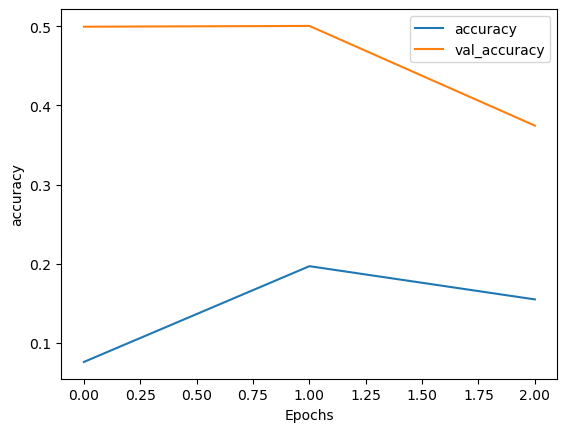

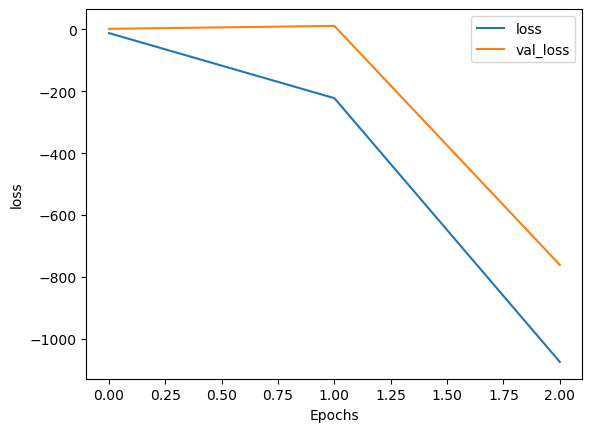

In [19]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")